© 2025 Zitao Yang, Rebecca J. Rousseau, Sara Mahdavi, Hernan G. Garcia, and Rob Phillips, *The dynamics of inducible genetic circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Feed-forward Loop

## General helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# helper functions
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Arguments:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

def normalize(x):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    return (x - min(x)) / (max(x) - min(x))

def normalize_pulse(x, xmax, xmin):
    """ Normalize an array such that 
    min(x) = xmin
    max(x) = xmax
    useful when the trajectory exhibits a pulse
    """
    print(xmin, xmax)
    return (x - xmin) / (xmax - xmin)

# Main text figures

## Fig. 21(A)

### Helper functions

**Note that the "delY" in all functions in the code is defined as $\mathcal{Y}_i - \mathcal{Y}_f$, which is in fact $-\Delta \mathcal{Y}$ as defined in the paper.**

In [2]:
def steadyStateFeedForward(X, rys, rzs, w, px, py, Ks):
    """ Find the coherent FFL steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
            
    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    if type(Y) is np.float64:
        return np.array([X, Y, Z])
    else:
        Xarray = np.full_like(Y, X)
        return [Xarray, Y, Z]

def steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks):
    """ Find the coherent simple regulation steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForward(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve coherent FFL dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
    
    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    # dY/dt
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    # dZ/dt
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    # linearly evolve the system
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleReg(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve coherent simple regulation dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: does not act
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    activation = (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    dRsdt[2] = - Rs[2] + activation
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def diff_func(ts, rs, w, X, delY, Yinf):
    """ Compute the difference between coherent FFL and simple regulation,
    also known as Theta(t)

    Arguments:
        - ts: time samples
        - rs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y

    Returns: Theta(t)
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    chi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    
    return np.exp(-ts)*(chi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta(rs, w, X, delY, Yinf):
    """ Compute the integral of Theta(t), for coherent FFL

    Arguments:
        - rs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y
    
    Returns: Integral of Theta(t) from t=0 to infinity
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1+w*X) / S)

plotting functions

In [3]:
def integrate_coherent_step(rys, rzs, w, Ks, nstep=3*10**4, delt=10**(-3), 
                           pmin=pAct(10**(-4)), pmax=pAct(10**(-7)), X=1, Y=1):
    """ Numerically integrate coherent FFL dynamics,
    when the signal is a step function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nstep: number of steps
        - delt: size of time step
        - pmin: low value of pact^X
        - pmax: high value of pact^X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # defining how inducer concentration is tuned
    empty = np.full(int(nstep/5), pmin)
    full = np.full(int(nstep/5), pmax)

    pxs = np.concatenate((empty, full, full, empty, empty))
    pys = np.full(nstep, pmax)

    # history of FFL concentrations
    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

    # history of simple regulation concentrations
    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

    # evolve the system
    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    # plot the trajectories
    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, Rs[:, 2], label=r"FFL")
    axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"Normalized Concentration")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A): Example coherent feed-forward loop response trajectory

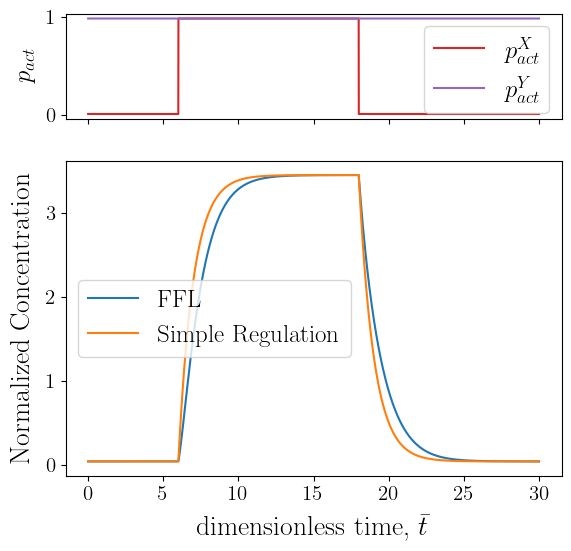

In [4]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1
Ks = [1, 1, 1]

integrate_coherent_step(rys, rzs, w, Ks)

## Fig. 22

### Helper functions

In [5]:
def delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1, plot=True):
    """ Sweep in (KXZ, KYZ) space and compute average time delay
    for an ON step

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """
    # creating 2d mesh  
    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # compute average time delay
    delta = np.abs(int_delta(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY))
    timescale = delta/(highZ - lowZ)

    if plot:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$\bar{K}_{XZ}$")
        ax.set_ylabel(r"$\bar{K}_{YZ}$")
        cbar = plt.colorbar(im)
        cbar.set_label(r"$\Delta \bar{t}$")
        plt.show()
    return np.max(timescale)

def delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1, plot=True):
    """ Sweep in (KXZ, KYZ) space and compute average time delay
    for an OFF step

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """

    # creating 2d mesh

    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # compute average time delay
    delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
    timescale = delta/(highZ - lowZ)

    if plot:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=4.5)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$\bar{K}_{XZ}$")
        ax.set_ylabel(r"$\bar{K}_{YZ}$")
        cbar = plt.colorbar(im)
        cbar.set_label(r"$\Delta \bar{t}$")
        plt.show()
    return np.max(timescale)

### (A)(i, ii): XOR gate

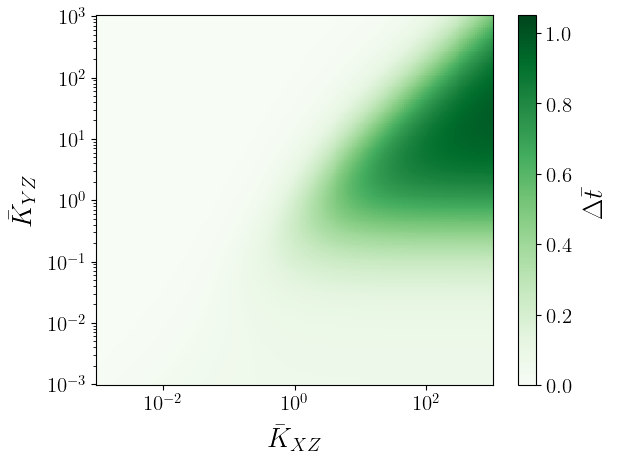

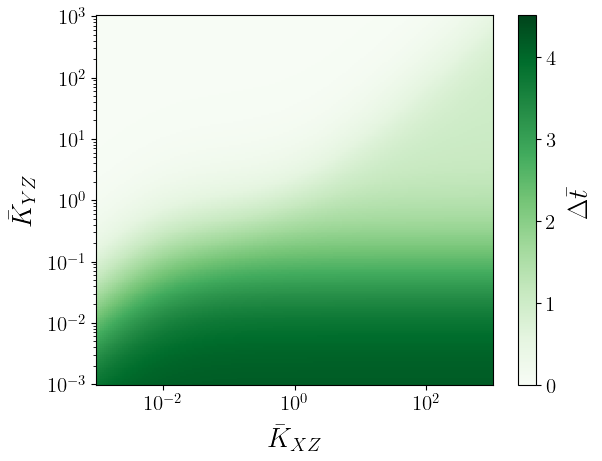

4.165579569360163

In [6]:
# XOR GATE, ON STEP

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)

### (B)(i, ii): AND gate

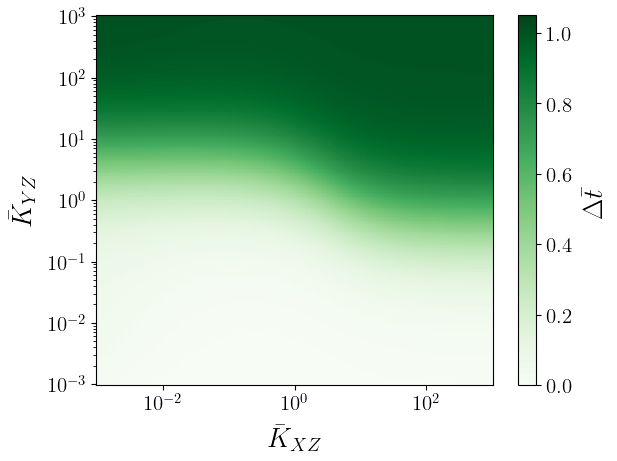

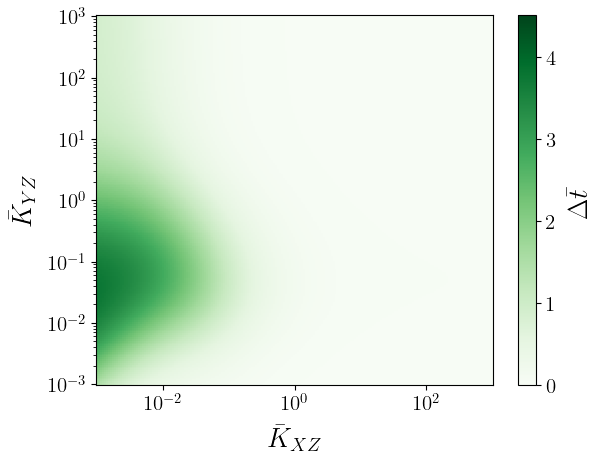

3.767817791287468

In [7]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)

### (C)(i, ii): OR gate

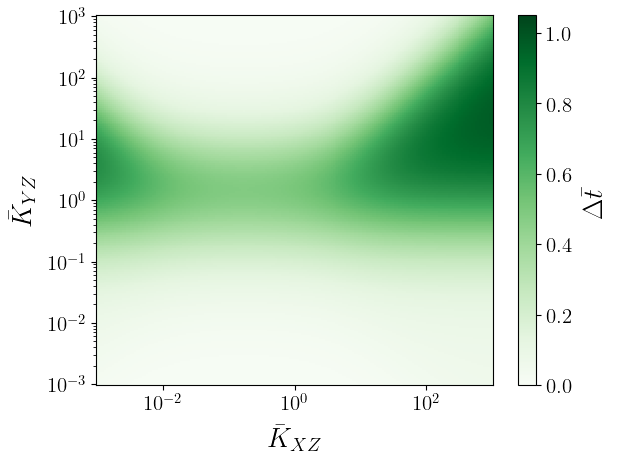

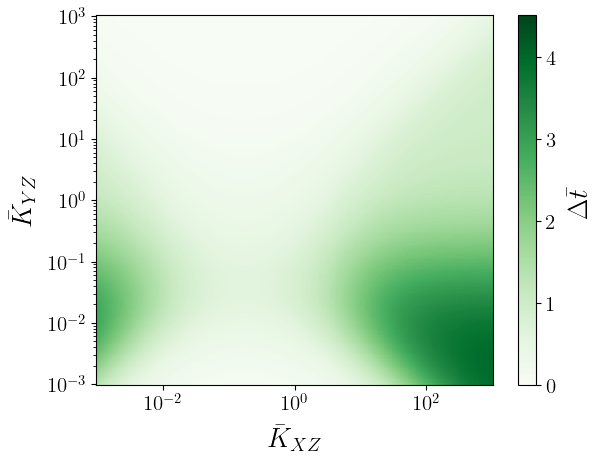

3.983405473298469

In [8]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)

### (A-C)(iii): Specific trajectories

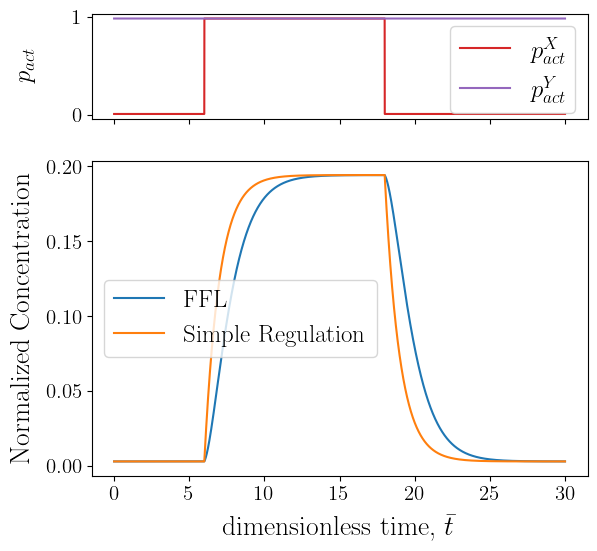

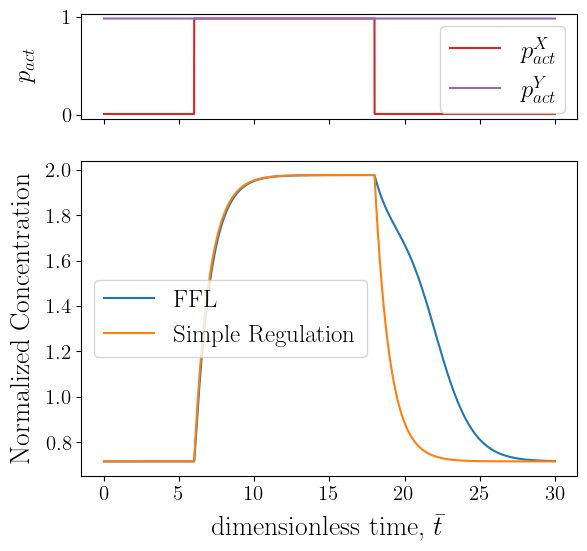

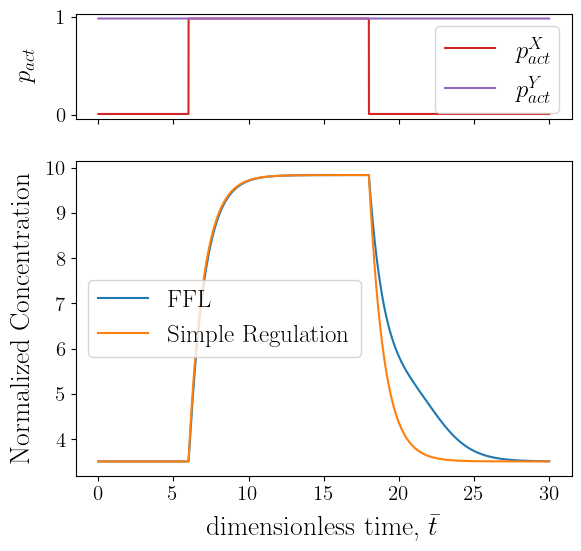

In [9]:
# (A) - XOR gate
rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 10**2, 10]

integrate_coherent_step(rys, rzs, w, Ks)

# (B) - AND gate
rys = [0, 2]
rzs = [0, 0, 2]
w = 10
Ks = [1, 10**(-2), 10**(-1)]

integrate_coherent_step(rys, rzs, w, Ks)

# (C) - OR gate
rys = [0, 2]
rzs = [0, 2, 10]
w = 1
Ks = [1, 10**(-2), 10**(-2)]

integrate_coherent_step(rys, rzs, w, Ks)

## Fig. 24

### Helper functions

In [10]:
# define the functions for incoherent FFL

def steadyStateFeedForwardIncoh(X, rys, rzs, w, px, py, Ks):
    """ Find the incoherent FFL steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
            
    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    return np.array([X, Y, Z])

def steadyStateSimpleRegIncoh(X, Y, rzs, w, px, py, Ks):
    """ Find the incoherent simple regulation steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForwardIncoh(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve incoherent FFL dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
    
    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleRegIncoh(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve incoherent simple regulation dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: does not act
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def diff_func_incoh(ts, rs, w, X, delY, Yinf):
    """ Compute the difference between incoherent FFL and simple regulation,
    also known as Theta(t)

    Arguments:
        - ts: time samples
        - rs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y

    Returns: Theta(t)
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)
    
    return np.exp(-ts)*(Phi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta_incoh(rs, w, X, delY, Yinf):
    """ Compute the integral of Theta(t), for incoherent FFL

    Arguments:
        - rs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y
    
    Returns: Integral of Theta(t) from t=0 to infinity
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)

    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1 + w*X) / S)

In [11]:
def integrate_incoherent_curve(rys, rzs, w, Ks, nstep=int(1.5*10**4), delt=10**(-3), 
                           pmin=pAct(10**(-4)), pmax=pAct(10**(-7)), X=1, Y=1):
    """ Numerically integrate incoherent FFL dynamics,
    when the signal is a step function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nstep: number of steps
        - delt: size of time step
        - pmin: low value of pact^X
        - pmax: high value of pact^X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # defining how inducer concentration is tuned
    empty = np.full(int(nstep/5), pmin)
    full = np.full(int(nstep/5), pmax)

    # Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
    # Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
    # Cys = np.full(nstep, 10**(-7))

    pxs = np.concatenate((empty, full, full, full, full))
    pys = np.full(nstep, pmax)

    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs[0], pys[0], Ks)

    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleRegIncoh(X, Y, rzs, w, pxs[0], pys[0], Ks)

    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    Zmax = steadyStateFeedForwardIncoh(X, rys, rzs, w, pmax, pmax, Ks)[2]
    Zmin = steadyStateFeedForwardIncoh(X, rys, rzs, w, pmin, pmax, Ks)[2]
    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])
    
    axs[1].plot(ts, Rs[:, 2], label=r"$Z_1$")
    axs[1].plot(ts, normalize(Rps[:, 2])*np.abs(Zmax - Zmin) + np.min([Zmax, Zmin]), label=r"Simple Reg")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"Normalized Concentration")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A), (B): Acceleration / pulse strength sweeps

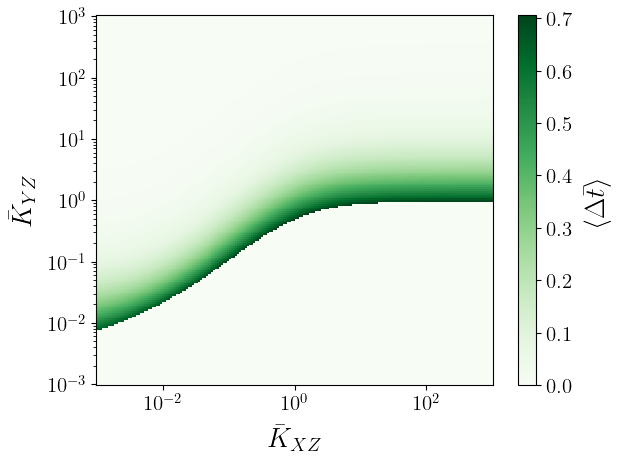

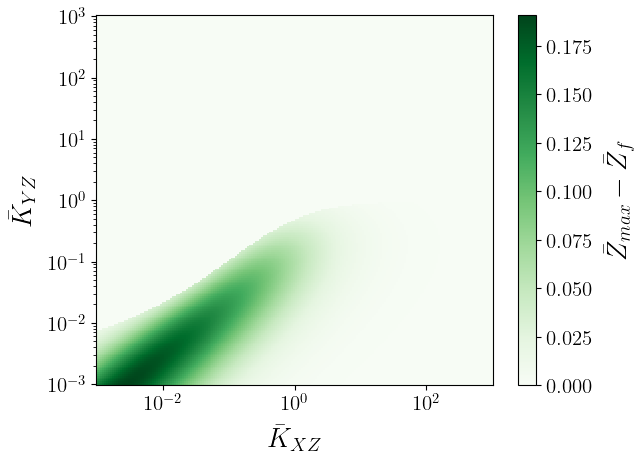

In [12]:
# pulse for ON step
# define system parameters
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200
plow = pAct(10**(-4))
phigh = pAct(10**(-7))

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

# compute initial and final steady states
[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

# maximal Z concentration reached by a trajectory
max_Z = np.zeros_like(KX)

for i in range(length):
    for j in range(length):
        # find maximal Z concentration given (KXZ, KYZ)
        diff = diff_func_incoh(ts, rzs, w, phigh*X/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        max_Z[i, j] = np.max(diff + lowZ[i, j]*np.exp(-ts) + highZ[i, j]*(1 - np.exp(-ts)))

# height of pulse
pulse_val = (max_Z - highZ)
# Delta Z
Zdiff = highZ - lowZ
# area between curves
delta_mag = int_delta_incoh(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY)
# set relative threshold
threshold = 0.05

# only consider time acceleration for the non strong pulses
time_acceleration = delta_mag/Zdiff
time_acceleration[pulse_val > threshold*Zdiff] = 0

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_acceleration, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{XZ}$")
ax.set_ylabel(r"$\bar{K}_{YZ}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$\langle\Delta\bar{t} \rangle$")
plt.show()

# only consider pulse values for the strong pulses
pulse_val[pulse_val < threshold*Zdiff] = 0

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{XZ}$")
ax.set_ylabel(r"$\bar{K}_{YZ}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$\bar{Z}_{max} - \bar{Z}_f$")
plt.show()

### (C), (D): Example trajectories

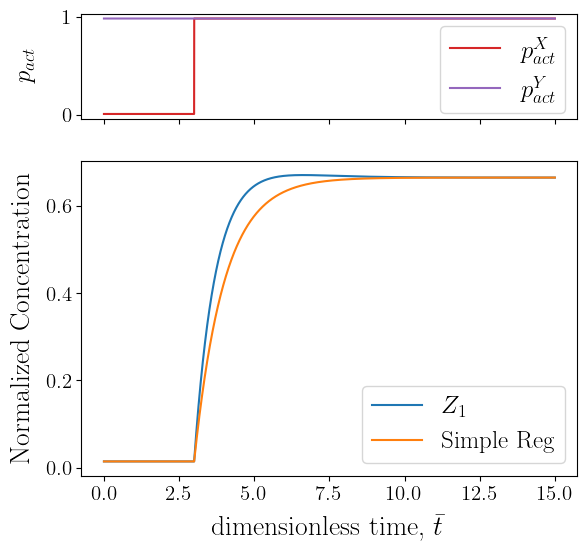

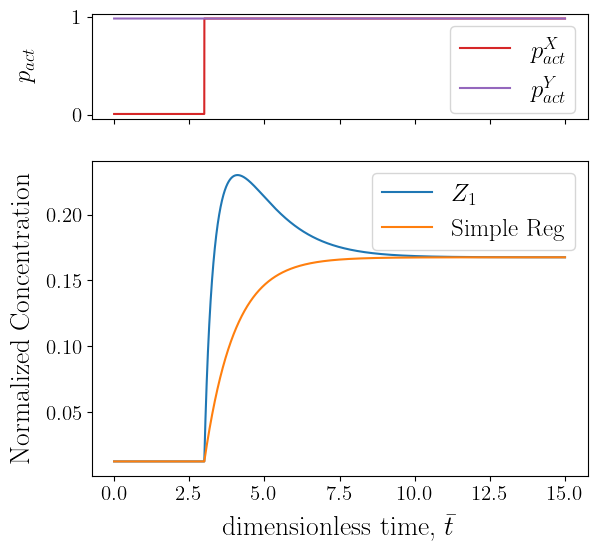

In [13]:
# (C)
rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 1, 1]

integrate_incoherent_curve(rys, rzs, w, Ks)

# (D)
rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 1, 0.1]

integrate_incoherent_curve(rys, rzs, w, Ks)

## Fig. 25

In [14]:
def integrate_coherent_continuous(rys, rzs, w, Ks, nc, nstep=5*10**4, delt=10**(-3), 
                           cmin=10**(-7), cmax=10**(-4), X=1, Y=1):
    """ Numerically integrate coherent FFL dynamics,
    when the signal is a continuous function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nc: number of steps it takes for signal to change
                from initial to final value
        - nstep: number of steps
        - delt: size of time step
        - cmin: low value of c_X
        - cmax: high value of c_X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # defining how inducer concentration is tuned
    nc = int(nc) # number of steps for a changing cX
    nf = int((nstep - 2*nc)/3) # number of steps for stationary cX

    # changing signals
    decrease = pAct(np.logspace(np.log10(cmin), np.log10(cmax), nc))
    increase = pAct(np.logspace(np.log10(cmax), np.log10(cmin), nc))

    # compute the timescale of effector variation
    critical_cs = [0.2, 0.8]
    [t1, t2] = np.interp(critical_cs, increase, np.linspace(0, nc*delt, nc))
    print(f"The timescale of effector variation, tc, is {np.around(np.abs(t1 - t2), 2)}")

    # stationary signals
    empty = np.full(nf, pAct(cmax))
    full = np.full(nf, pAct(cmin))

    # define the entire trajectory of pact,X and pact, Y
    pxs = np.concatenate((empty, increase, full, decrease, empty))
    pys = np.full(nstep, pAct(cmin))

    # history of FFL concentrations
    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

    # history of simple regulation concentrations
    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

    # plot the trajectories
    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, Rs[:, 2], label=r"FFL")
    axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"output concentration, $\bar{Z}$")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A) Fast-speed tuning

The timescale of effector variation, tc, is 0.24


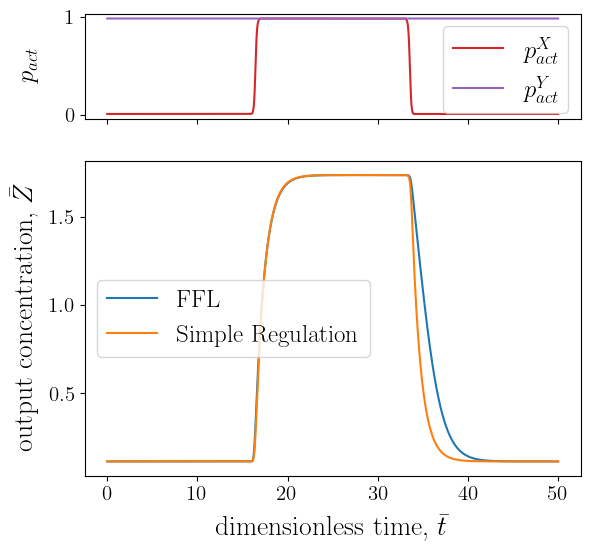

In [15]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 1000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

### (B) Middle-speed tuning

The timescale of effector variation, tc, is 1.65


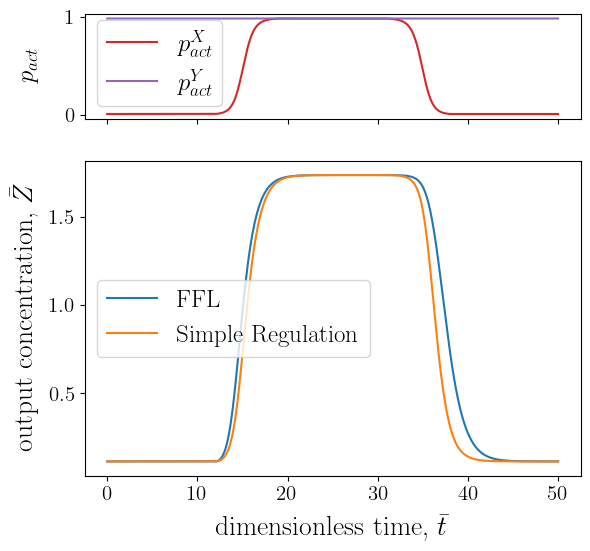

In [16]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 7000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

### (C) Slow-speed tuning

The timescale of effector variation, tc, is 5.18


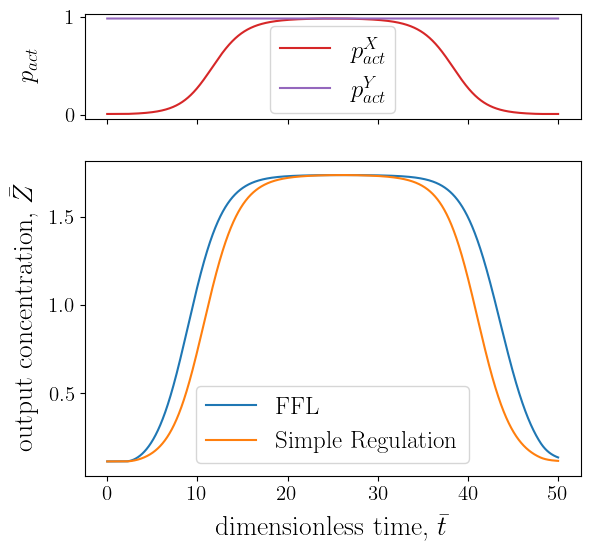

In [17]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 22000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

# Appendix figures

## Fig. 35

In [18]:
def delZ_colormap(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1):
    """ Sweep in (KXZ, KYZ) space and compute Delta Z

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """

    # creating 2d mesh
    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # take the difference to find Delta Z
    delZ = highZ - lowZ

    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, delZ, cmap="Greens", rasterized = True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\bar{K}_{XZ}$")
    ax.set_ylabel(r"$\bar{K}_{YZ}$")
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\Delta \bar{Z}$")
    plt.show()

### (A): XOR gate

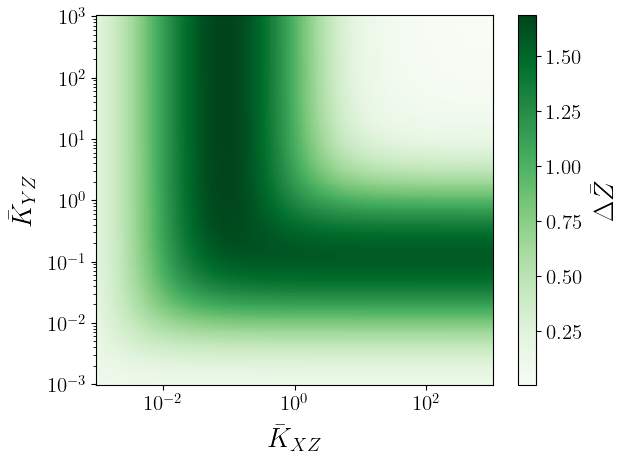

In [19]:
rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

### (B): AND gate

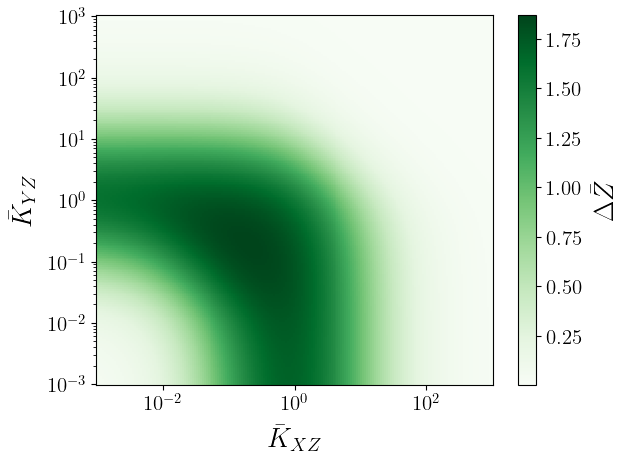

In [20]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

### (C): OR gate

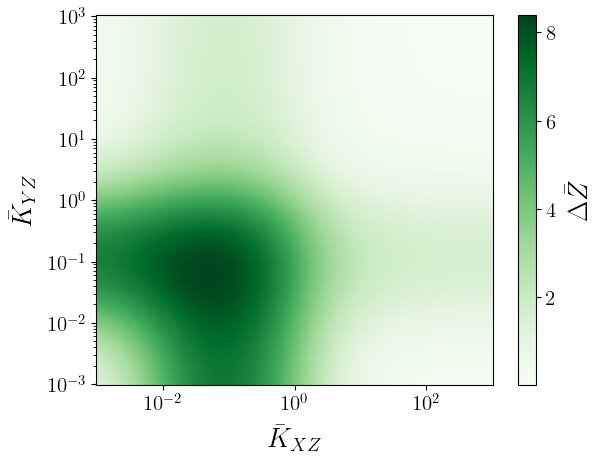

In [21]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

## Fig. 36

### Mega sweep function

In [22]:
length = 20
default_params = np.array([0, 1, 5, 5, 1], dtype=float)
labels = [r"$\bar{r}_0$", r"$\bar{r}_1$", r"$\bar{r}_2$",
          r"$\omega$", r"$\bar{X}$"]

def delt_sweep_OFF(default_params, sweep_params, labels, where, length=20,
                   Kxzs=np.logspace(-3, 3, 100), Kyzs=np.logspace(-3, 3, 100),
                   plow=pAct(10**(-4)), phigh=pAct(10**(-7)),
                   xlog=False, ylog=False, vmin=0, vmax=5):
    """ Sweep across 4 parameters at a time,
    including two parameters of choice, and (KXZ, KYZ),
    and compute average time delay in coherent FFL
    
    Arguments:
        - default_params: default set of parameters
            [r0, r1, r2, w, X]
        - sweep_params: list of parameter arrays to be swept
        - labels: labels for each parameter
        - where: position of the parameters to be swept
        - length: length of parameter sweep array
        - Kxzs: array of Kxz to be swept
        - Kyzs: array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - xlog: plot the x-axis in log scale if True
        - ylog: plot the y-axis in log scale if True
        - vmin: minimal value for colorbar
        - vmax: maximal value for colorbar
    """
    m, n = where
    sweep1 = sweep_params[m]
    sweep2 = sweep_params[n]
    S1, S2 = np.meshgrid(sweep1, sweep2)

    max_delt = np.zeros_like(S1)

    params = np.copy(default_params)

    for i in range(length):
        for j in range(length):
            params[m] = S1[i, j]
            params[n] = S2[i, j]
            r0, r1, r2, w, X = np.copy(params)
            max_delt[i, j] = delt_colormap_OFF([r0, r1], [r0, r1, r2], w, 
                                               Kxzs, Kyzs, plow, phigh, X, plot=False)
            
    fig, ax = plt.subplots()
    im = ax.pcolormesh(S1, S2, max_delt, cmap="Greens", rasterized = True, vmin=vmin, vmax=vmax)
    if xlog:
        ax.set_xscale("log")
    if ylog:
        ax.set_yscale("log")
    plt.xlabel(labels[m])
    plt.ylabel(labels[n])
    plt.colorbar(im)
    plt.show()
    print(f"Maximal time delay found is {np.max(max_delt)}")

### Parameter sweeps

In order, we are sweeping (r0, r1), (r0, r2), (r0, w), (r0, X), (r1, r2), (r1, w), (r1, X), (r2, w), (r2, X), (w, X).

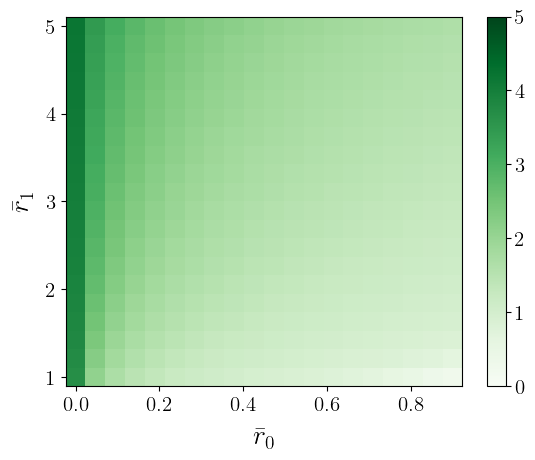

Maximal time delay found is 4.199150953046187


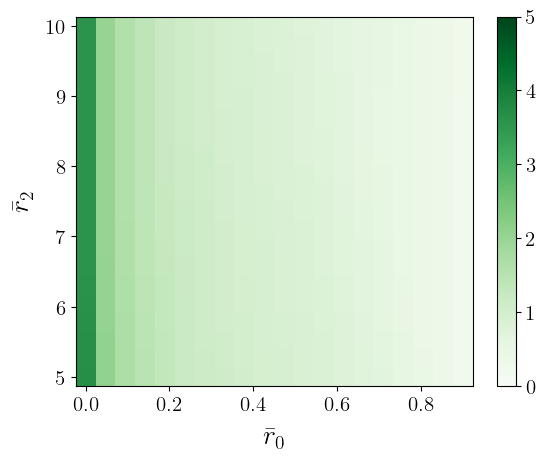

Maximal time delay found is 3.686839041357649


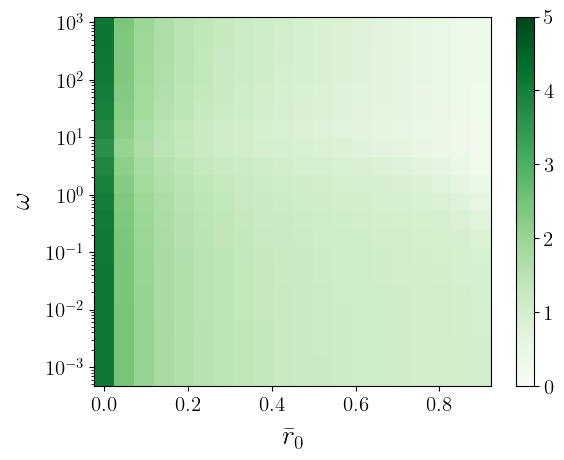

Maximal time delay found is 4.169796003054271


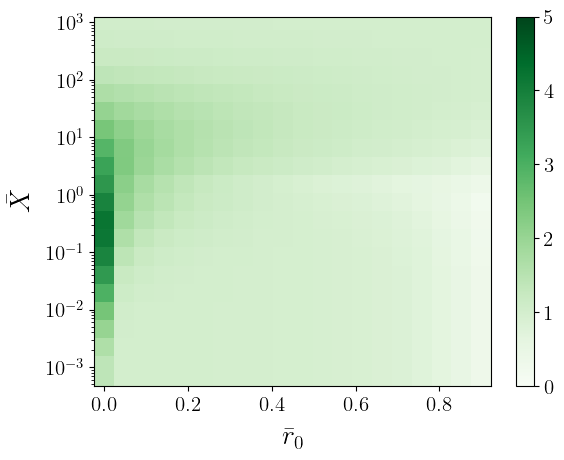

Maximal time delay found is 4.20020116029027


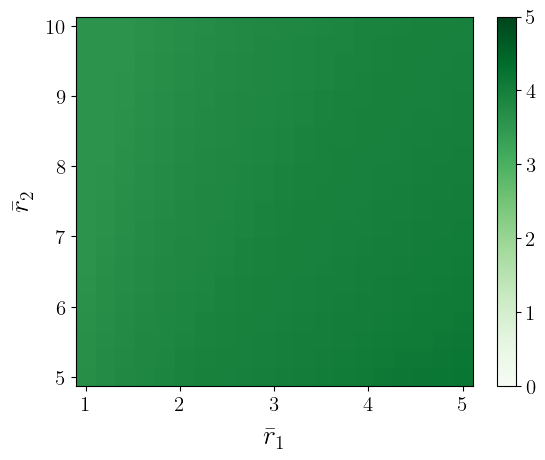

Maximal time delay found is 4.199150953046187


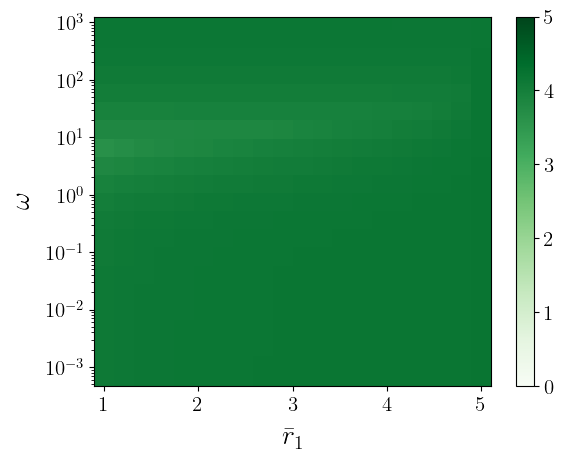

Maximal time delay found is 4.199461053694709


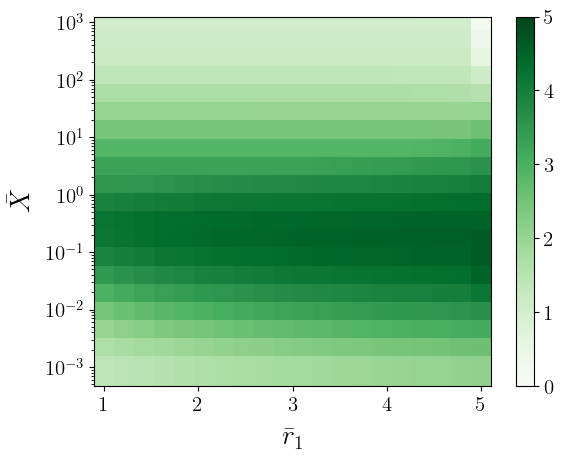

Maximal time delay found is 4.637267009525095


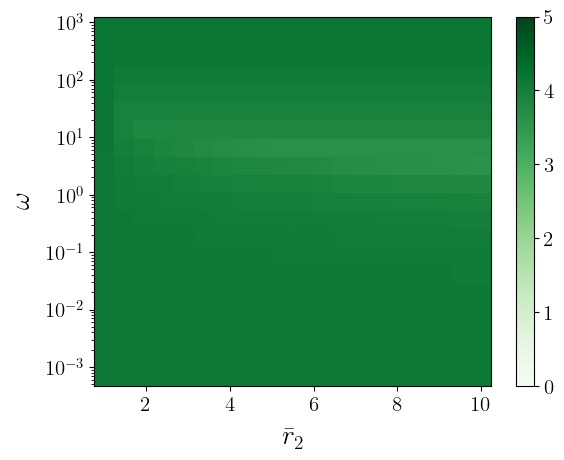

Maximal time delay found is 4.1703295849119275


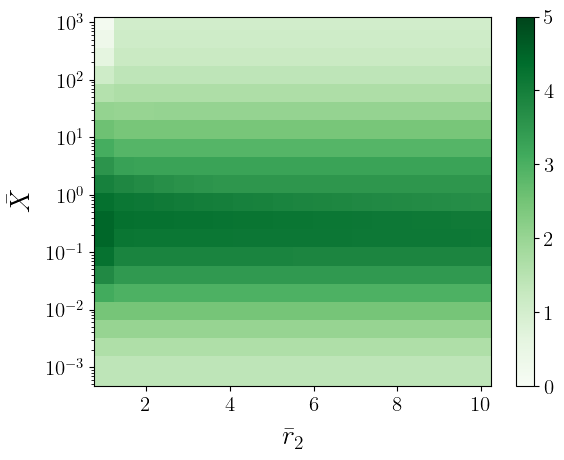

Maximal time delay found is 4.4686454193305245


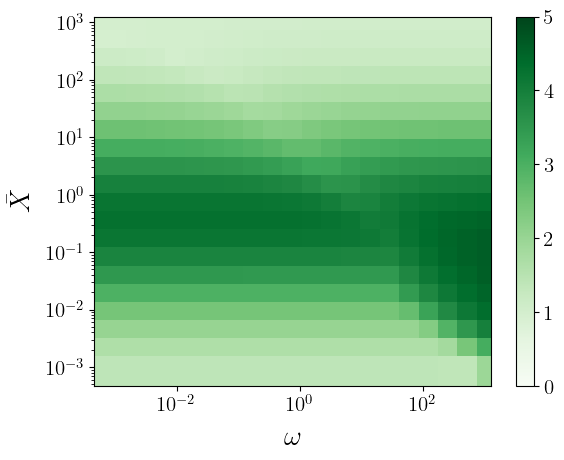

Maximal time delay found is 4.608557009923977


In [23]:
r0s = np.linspace(0, 0.9, length)
r1s = np.linspace(1, 5, length)
r2s_vert = np.linspace(5, 10, length)
r2s_hor = np.linspace(1, 10, length)
ws = np.logspace(-3, 3, length)
xs = np.logspace(-3, 3, length)

sweep_params1 = [r0s, r1s, r2s_vert, ws, xs]
sweep_params2 = [r0s, r1s, r2s_hor, ws, xs]

# r0, r1
where = np.array([0, 1], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r0, r2
where = np.array([0, 2], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r0, w
where = np.array([0, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r0, X
where = np.array([0, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r1, r2
where = np.array([1, 2], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r1, w
where = np.array([1, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r1, X
where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r2, w
where = np.array([2, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, ylog=True)

# r2, X
where = np.array([2, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, ylog=True)

# w, X
where = np.array([3, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, xlog=True, ylog=True)

## Fig. 37

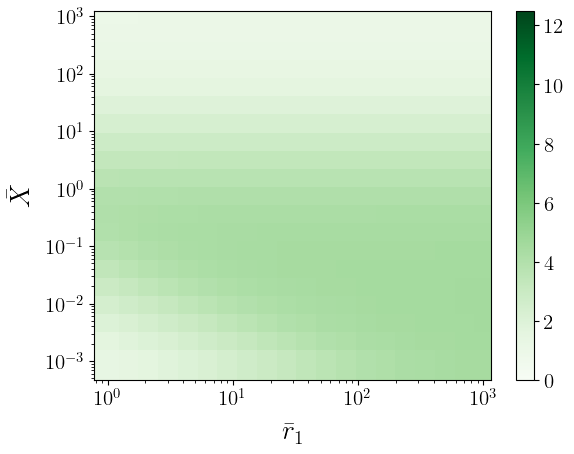

Maximal time delay found is 4.547287720859733


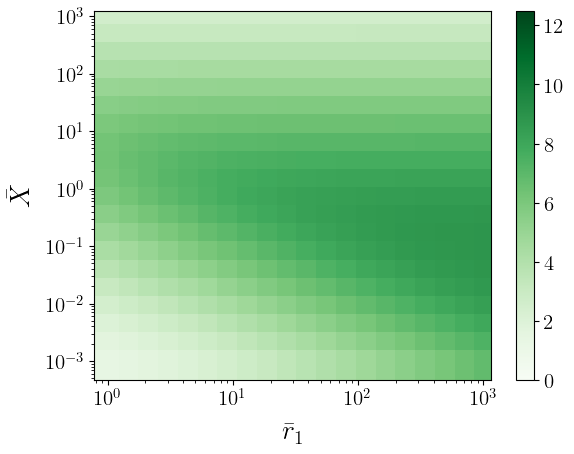

Maximal time delay found is 8.878343717963112


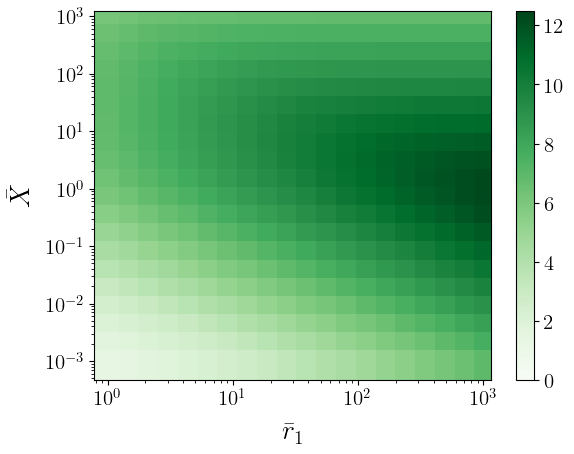

Maximal time delay found is 12.308807602521764


In [24]:
length = 20
default_params = np.array([0, 1, 5, 0, 1], dtype=float)
labels = [r"$\bar{r}_0$", r"$\bar{r}_1$", r"$\bar{r}_2$",
          r"$\omega$", r"$\bar{X}$"]

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 3, length)

sweep_params1 = [r0s, r1s, r2s_vert, ws, xs]
sweep_params2 = [r0s, r1s, r2s_hor, ws, xs]

# pmin = 10^(-2)
where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-2),
               xlog=True, ylog=True, vmin=0, vmax=12.5)

# pmin = 10^(-4)
where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-4),
               xlog=True, ylog=True, vmin=0, vmax=12.5)

# pmin = 10^(-6)
where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-6),
               xlog=True, ylog=True, vmin=0, vmax=12.5)